# Maple Syrup

In [2]:
!pip install ortools

  Obtaining dependency information for ortools from https://files.pythonhosted.org/packages/3c/38/b2e915c4b3f3bf966d2d73e69ee4c72a09452822ea912af0a506a32e2a48/ortools-9.11.4210-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=2.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for protobuf<5.27,>=5.26.1 from https://files.pythonhosted.org/packages/2c/2a/d2741cad35fa5f06d9c59dda3274e5727ca11075dfd7de3f69c100efdcad/protobuf-5.26.1-cp37-abi3-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for immutabledict>=3.0.0 from https://files.pythonhosted.org/packages/e2/13/3cf4ac5b3403f3456e645c4533883ef67b1bb0c72e56b79c707715f57a74/immutabledict-4.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━

In [3]:
try:
    from ortools.graph.python import max_flow
except ImportError:
    print("Please install ortools with the following command: pip install ortools")
    raise ImportError("Please install ortools with the following command: pip install ortools")


#source: https://developers.google.com/optimization/flow/maxflow
def main():
    """MaxFlow simple interface example."""
    # Instantiate a SimpleMaxFlow solver.
    smf = max_flow.SimpleMaxFlow()

    start_nodes = []
    end_nodes = []
    capacities = []

    with open('canadian_cities.txt', 'r') as file:
        data = [line.strip().split() for line in file]

        for entry in data:
            start_nodes.append(entry[0])
            end_nodes.append(entry[1])
            capacities.append(int(entry[2]))  

    # Create a set of unique city names
    city_names = set(start_nodes + end_nodes)

    # Create a mapping from city names to integer IDs
    city_to_id = {city: idx for idx, city in enumerate(city_names)}
    id_to_city = {idx: city for city, idx in city_to_id.items()}

    # Replace city names with integer IDs in start_nodes and end_nodes
    start_node_ids = [city_to_id[city] for city in start_nodes]
    end_node_ids = [city_to_id[city] for city in end_nodes]

    # Add arcs in bulk.
    # Note: We could have used add_arc_with_capacity(start, end, capacity)
    all_arcs = smf.add_arcs_with_capacity(start_node_ids, end_node_ids, capacities)

    # Define the source and sink nodes (replace 'Argentia' and 'Inuvik' with your actual source and sink)
    source_city = 'Argentia'
    sink_city = 'Inuvik'
    source = city_to_id[source_city]
    sink = city_to_id[sink_city]

    # Find the maximum flow between the source and sink nodes
    status = smf.solve(source, sink)

    if status != smf.OPTIMAL:
        print("There was an issue with the max flow input.")
        print(f"Status: {status}")
        exit(1)

    print(f"Max flow from {source_city} to {sink_city}: {smf.optimal_flow()}\n")
    print(" Arc    Flow / Capacity")
    solution_flows = smf.flows(all_arcs)
    for arc, flow, capacity in zip(all_arcs, solution_flows, capacities):
        tail_city = id_to_city[smf.tail(arc)]
        head_city = id_to_city[smf.head(arc)]
        print(f"{tail_city} -> {head_city}   {flow:3}  / {capacity:3}")

    print("\nSource side min-cut:", [id_to_city[node] for node in smf.get_source_side_min_cut()])
    print("Sink side min-cut:", [id_to_city[node] for node in smf.get_sink_side_min_cut()])

# if __name__ == "__main__":
#     main()


In [4]:
main()

Max flow from Argentia to Inuvik: 2500

 Arc    Flow / Capacity
Argentia -> Brandon   1700  / 2000
Argentia -> Calgary   800  / 1500
Brandon -> Dartmouth   700  / 1500
Brandon -> Edmonton   1000  / 1000
Calgary -> Fredericton     0  / 500
Calgary -> Edmonton   800  / 2000
Dartmouth -> Guelph   300  / 800
Edmonton -> Halifax   800  / 1200
Fredericton -> Guelph   400  / 600
Guelph -> Halifax   700  / 700
Halifax -> Inuvik   1500  / 1500
Edmonton -> Inuvik   1000  / 1000
Dartmouth -> Fredericton   400  / 400
Calgary -> Dartmouth     0  / 1000

Source side min-cut: ['Argentia', 'Brandon', 'Calgary', 'Dartmouth', 'Fredericton', 'Edmonton', 'Guelph', 'Halifax']
Sink side min-cut: ['Inuvik']


## Hand rolled Ford - Fulkerson approach

In [7]:



class Graph:
    def __init__(self):
        self.adjacency_list={}

    def add_node(self, node):
        if node not in self.adjacency_list:
            self.adjacency_list[node]=[]

    def add_edge(self, from_node, to_node, capacity):
        self.add_node(from_node)
        self.add_node(to_node)
        self.adjacency_list[from_node].append((to_node, capacity))

    def get_neighbours(self, node):
        return self.adjacency_list.get(node, [])

    def __str__(self):
        return str(self.adjacency_list)


def dfs(graph, current_node, target_node, path_flow, flow_graph, visited=None):
    if visited is None:
        visited = set()

    if current_node == target_node:
        return path_flow
    visited.add(current_node)

    for neighbor, capacity in graph.get_neighbours(current_node):
        if neighbor not in flow_graph[current_node]:
            flow_graph[current_node][neighbor] = 0
        if current_node not in flow_graph[neighbor]:
            flow_graph[neighbor][current_node] = 0

        residual_capacity = capacity - flow_graph[current_node][neighbor]
        if neighbor not in visited and residual_capacity > 0:
            min_capacity = min(path_flow, residual_capacity)
            result = dfs(graph, neighbor, target_node, min_capacity, flow_graph, visited)
            if result > 0:
                flow_graph[current_node][neighbor] += result
                flow_graph[neighbor][current_node] -= result
                return result
    return 0

def ford_fulkerson(graph, source, sink):
    flow_graph = {node: {} for node in graph.adjacency_list}
    for u in graph.adjacency_list:
        for v, _ in graph.adjacency_list[u]:
            flow_graph[u][v] = 0

    max_flow = 0

    while True:
        path_flow = dfs(graph, source, sink, float('Inf'), flow_graph, visited=set())
        if path_flow == 0:
            break
        max_flow += path_flow

    return max_flow, flow_graph
def initialize_graph(filename):
    graph = Graph()
    with open(filename, 'r') as file:
        for line in file:
            entry = line.split(" ")
            from_city = entry[0]
            to_city = entry[1]
            capacity = int(entry[2])

            graph.add_edge(from_city,to_city,capacity)
    return graph

def run_ff(filename, source, sink):
    graph = initialize_graph(filename)
    return ford_fulkerson(graph, source, sink)


In [9]:
flow, flow_graph = run_ff('canadian_cities.txt', 'Argentia', 'Inuvik')
print(f"Max flow: {flow}")
print("Flow graph:")
for node in flow_graph:
    print(f"{node}: {flow_graph[node]}")

Max flow: 2500
Flow graph:
Argentia: {'Brandon': 1700, 'Calgary': 800}
Brandon: {'Dartmouth': 700, 'Edmonton': 1000, 'Argentia': -1700}
Calgary: {'Fredericton': 0, 'Edmonton': 800, 'Dartmouth': 0, 'Argentia': -800}
Dartmouth: {'Guelph': 700, 'Fredericton': 0, 'Brandon': -700, 'Calgary': 0}
Edmonton: {'Halifax': 800, 'Inuvik': 1000, 'Brandon': -1000, 'Calgary': -800}
Fredericton: {'Guelph': 0, 'Dartmouth': 0, 'Calgary': 0}
Guelph: {'Halifax': 700, 'Dartmouth': -700, 'Fredericton': 0}
Halifax: {'Inuvik': 1500, 'Guelph': -700, 'Edmonton': -800}
Inuvik: {'Halifax': -1500, 'Edmonton': -1000}


## Visualization of our flows

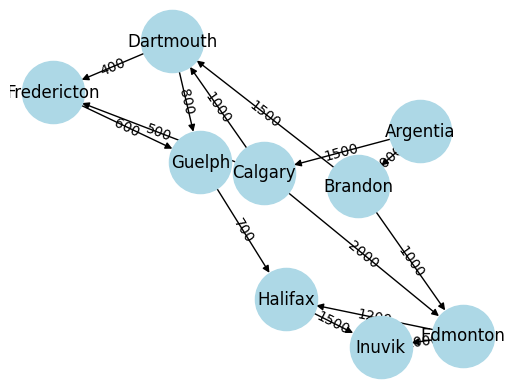

In [10]:
# we want to plot the graph with Argentia as the source on the left
# and Inuvik as the sink on the right

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

with open('canadian_cities.txt', 'r') as file:
    data = [line.strip().split() for line in file]

for entry in data:
    G.add_edge(entry[0], entry[1], capacity=int(entry[2]))
pos = nx.spring_layout(G)
edge_labels = {(u, v): d['capacity'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
plt.show()


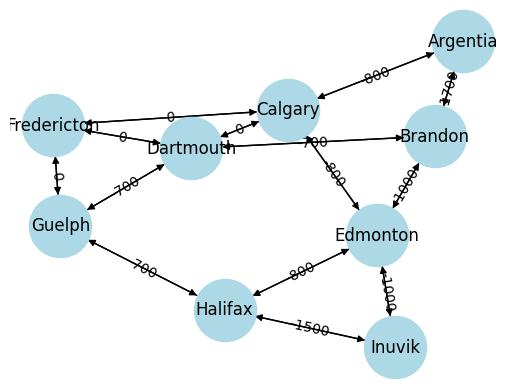

In [11]:
# let's plot the flow graph
flow_graph_nx = nx.DiGraph()
for u in flow_graph:
    for v in flow_graph[u]:
        flow_graph_nx.add_edge(u, v, capacity=flow_graph[u][v])

pos = nx.spring_layout(flow_graph_nx)
edge_labels = {(u, v): d['capacity'] for u, v, d in flow_graph_nx.edges(data=True)}
nx.draw_networkx_edge_labels(flow_graph_nx, pos, edge_labels=edge_labels)
nx.draw(flow_graph_nx, pos, with_labels=True, node_size=2000, node_color='lightblue')
plt.show()

In [13]:
# let's print flow graph again
print("Flow graph:")
for node in flow_graph:
    print(f"{node}: {flow_graph[node]}")

Flow graph:
Argentia: {'Brandon': 1700, 'Calgary': 800}
Brandon: {'Dartmouth': 700, 'Edmonton': 1000, 'Argentia': -1700}
Calgary: {'Fredericton': 0, 'Edmonton': 800, 'Dartmouth': 0, 'Argentia': -800}
Dartmouth: {'Guelph': 700, 'Fredericton': 0, 'Brandon': -700, 'Calgary': 0}
Edmonton: {'Halifax': 800, 'Inuvik': 1000, 'Brandon': -1000, 'Calgary': -800}
Fredericton: {'Guelph': 0, 'Dartmouth': 0, 'Calgary': 0}
Guelph: {'Halifax': 700, 'Dartmouth': -700, 'Fredericton': 0}
Halifax: {'Inuvik': 1500, 'Guelph': -700, 'Edmonton': -800}
Inuvik: {'Halifax': -1500, 'Edmonton': -1000}


In [14]:
# let's plot all cities as scatter plot
# we will connect the cities with the flow values using arrows

# first let's remove negative values from the flow graph
flow_graph_positive = {u: {v: flow_graph[u][v] for v in flow_graph[u] if flow_graph[u][v] >= 0} for u in flow_graph}

# let's print positive flow graph
print("Positive flow graph:")
for node in flow_graph_positive:
    print(f"{node}: {flow_graph_positive[node]}")


Positive flow graph:
Argentia: {'Brandon': 1700, 'Calgary': 800}
Brandon: {'Dartmouth': 700, 'Edmonton': 1000}
Calgary: {'Fredericton': 0, 'Edmonton': 800, 'Dartmouth': 0}
Dartmouth: {'Guelph': 700, 'Fredericton': 0, 'Calgary': 0}
Edmonton: {'Halifax': 800, 'Inuvik': 1000}
Fredericton: {'Guelph': 0, 'Dartmouth': 0, 'Calgary': 0}
Guelph: {'Halifax': 700, 'Fredericton': 0}
Halifax: {'Inuvik': 1500}
Inuvik: {}


In [18]:
# now let's plot the cities as scatter plot using Plotly
# we will connect the cities with the flow values using arrows


cities = list(flow_graph_positive.keys())

# our placement will be Argentia on the left and Inuvik on the right 
# the other cities will be placed in two rows in the middle

# so if we have 600 width and 800 height then Argentinia will be at (50, 400) and Inuvik at (550, 400)

# the other cities will be placed in two rows in the middle

# let's calculate the positions of the cities
import numpy as np

width = 600
height = 800

# so let's create a dictionary of city positions
city_positions = {
    'Argentia': (50, 400),
    'Inuvik': (550, 400)
}

# let's calculate the positions of the other cities
cities_middle = cities[1:-1]
n = len(cities_middle)
for i, city in enumerate(cities_middle):
    x = 100 + i * 400 / n
    y = 600 if i % 2 == 0 else 200
    city_positions[city] = (x, y)

# let's print the city positions
print("City positions:")
for city in city_positions:
    print(f"{city}: {city_positions[city]}")
    



City positions:
Argentia: (50, 400)
Inuvik: (550, 400)
Brandon: (100.0, 600)
Calgary: (157.14285714285714, 200)
Dartmouth: (214.28571428571428, 600)
Edmonton: (271.42857142857144, 200)
Fredericton: (328.57142857142856, 600)
Guelph: (385.7142857142857, 200)
Halifax: (442.85714285714283, 600)


In [22]:
# now let's plot the cities as scatter plot using Plotly

import plotly.express as px

fig = px.scatter(x=[city_positions[city][0] for city in city_positions], 
                 y=[city_positions[city][1] for city in city_positions], 
                 text=[city for city in city_positions])

# now let's add arrows between the cities
for u in flow_graph_positive:
    for v in flow_graph_positive[u]:
        x0, y0 = city_positions[u]
        x1, y1 = city_positions[v]
        fig.add_shape(type="line",
                      x0=x0, y0=y0, x1=x1, y1=y1,
                      line=dict(color="black", width=1),
                      opacity=0.5)
        # add a bit of text in the middle of the line but we want a bit of random offset
        # fig.add_annotation(x=(x0 + x1) / 2 + np.random.randint(-10, 10), y=(y0 + y1) / 2 + np.random.randint(-10, 10), showarrow=False,
        #                    text=f"{flow_graph_positive[u][v]}",
        #                    font=dict(color="black", size=10))
        fig.add_annotation(x=(x0 + x1) / 2, y=(y0 + y1) / 2, showarrow=False,
                           text=f"{flow_graph_positive[u][v]}",
                           font=dict(color="black", size=10))

fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.show()